# Merging classification results

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import evaluate
import merge
import load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load evaluation data
test_columns = ['returnQuantity', 'articleID', 'productGroup', 'customerID', 'voucherID']
test_predictions = merge.merged_predictions(test=True, keep_columns=test_columns)
test_train = evaluate.test_complement(test_predictions)

# Load classification data
class_columns = ['articleID', 'productGroup', 'customerID', 'voucherID',]
class_predictions = merge.merged_predictions(keep_columns=class_columns)
class_train = load.orders_train()

## Highest possible precision
We are interested in finding out how different our classifiers are specialised. Therefore, a possible measure is to take a look at the highest possible precision. In particular we want to find out how good we can perform if it was possible to always pick the correct prediction, if at least one group has predicted so.

In [5]:
preds = test_predictions.prediction
labels = test_predictions.original.returnQuantity
optimum = len(preds[(preds.A == labels) | (preds.B == labels) | (preds.C == labels)]) / len(preds)
disagreement = len(preds[(preds.A != preds.B) | (preds.A != preds.C)]) / len(preds)
optimum, disagreement

(0.7637576901698585, 0.21270896764621353)

It turns out that $0.763757$ is the highest reachable value knowing the prediction labels. This initially shows that we have a chance to improve predictions in comparison to every single result. On the other hand it has to be determined how many of the rows which have been classified differntly were actually guessing. The three results disagree in around 21% of the rows giving room for optimization.

## Confidences
### Imputation

Approximately 4% of predictions by team C have unknown confidences, making imputation necessary before merge approaches based on confidence can be applied. Because of this relatively small number, I propose to impute missing values using the mean confidence of Team C. The mean showed stable behavior across all splits in the test and prediction data.

Instead of using the actual values, I propose to redefine the confidence in standard-deviations distance from the mean.

$$ conf_{i,c} = 1 + \frac{conf_{i,c} - \mu_c}{\sigma_c} * \frac{1}{max(conf_c)}$$

with $conf_{i,c}$ being the confidence of classification $c$ in row $i$. To confine the range in [-1, 1], the confidences for each classifier are divided by its maximum confidence. The center of the distributions is then moved to 1, making the confidences applicable as multiplier weights. NaN values are filled with ones (then representing the mean).

This approach centers the central tendencies at 1 and decreases the differences in the ranges by setting the standard deviations to 1.

The figure below shows the distributions of the imputed predictions.

In [8]:
# Violinplot for class data and evaluation data
def confidence_plot(class_data, evaluation_data):  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    ax1.set_title('Classification')
    ax = sns.violinplot(data=class_data['confidence'], ax=ax1)
    ax2.set_title('Evaluation')
    ax = sns.violinplot(data=evaluation_data['confidence'], ax=ax2)

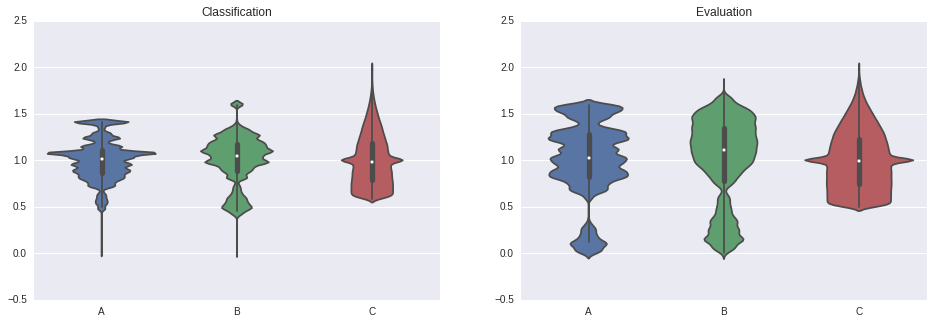

In [9]:
# Impute zeroes and convert confidenes to std-distances
class_imputed = merge.impute_confidence(class_predictions)
test_imputed = merge.impute_confidence(test_predictions)

# Violinplot for imputed data
confidence_plot(class_imputed, test_imputed)

## Approach 4: Boost results using another classifier
Due to lack of comparability between confidence values and the probably problematic imputation of confidence values it might be interesting to follow the approach of Boosting. This means we look at the results the respective classifiers gave and try to vote always for the best in a given case. Imposing this as a machine learning problem we have as feature vector
$\boldsymbol{t}_k=(pred_k^A, pred_k^B, prediction_k^C, conf_k^A, conf_k^B, conf_k^C, art_k, cust_k, voucher_k, prod_k)$ while the last four arguments are binary and tell us if the respective category is known before evaluation. Further as target we have again class labels which refer binarily to *returned* or *not returned*. Thus, we have $y=returned, y \in \{0,1\}$ as possible labels.

We already know from section **Highest possible precision** that in around 21% of the rows we find disagreement. All other rows are not interesting for this problem and we won't touch them or learn anything from them.

### Baseline - Only using the most precise classifier
Is there one result which we can always use to resolve disagreement? We have to look at different performances when classifiers disagree.

In [10]:
agree_mask = ((test_predictions.prediction.A == test_predictions.prediction.B) & 
              (test_predictions.prediction.A == test_predictions.prediction.C))
baseline = merge.precision(test_predictions.original.returnQuantity[agree_mask],
                           test_predictions.prediction.B[agree_mask])
baseline_weight = len(preds[agree_mask])
baseline

0.69993014003494847

If classifiers agree, the precision is near 70% which is extremely good in comparison to single results. This shows that the 21% disagreement make a huge difference in classification error.

In [11]:
disagree_mask = ((test_predictions.prediction.A != test_predictions.prediction.B) | 
                 (test_predictions.prediction.A != test_predictions.prediction.C))
y_labels = test_predictions.original.returnQuantity[disagree_mask]

#### A, B, C on disagreement (baseline for boosting on disagreed rows)

In [12]:
a = merge.precision(y_labels, test_predictions.prediction.A[disagree_mask])
b = merge.precision(y_labels, test_predictions.prediction.B[disagree_mask])
c = merge.precision(y_labels, test_predictions.prediction.C[disagree_mask])
a, b, c

(0.45814186362326992, 0.54310640457606896, 0.55259187116774799)

### Optimizing accuracy using DecisionTree and SVM with k-fold parameter optimization and k-fold cross validation for final estimation

In [13]:
from sklearn import preprocessing
from sklearn import svm
from sklearn import grid_search
from sklearn import cross_validation
from sklearn import pipeline
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from operator import itemgetter

In [14]:
categories = ['articleID', 'productGroup', 'customerID', 'voucherID']
X, y = merge.boosting_features(test_train, test_imputed, categories)

### SVM

In [12]:
steps = [('scaling', preprocessing.StandardScaler()),
         ('svm', svm.SVC())]
clf = pipeline.Pipeline(steps)
svc_params = [
    dict(svm__C=[0.5, 1.0, 5.0], svm__kernel=['poly'], svm__gamma=[0.1, 0.01, 0.5], svm__degree=[1, 2, 3, 4]),
    dict(svm__C=[0.5, 1.0, 5.0], svm__kernel=['rbf'], svm__gamma=[0.1, 0.01, 0.5])]
gs1 = grid_search.RandomizedSearchCV(clf, svc_params[0], n_jobs=-1, n_iter=36)
gs1.fit(X[:2500], y[:2500])
x1 = gs1.score(X, y)
gs2 = grid_search.RandomizedSearchCV(clf, svc_params[1], n_jobs=-1, n_iter=9)
gs2.fit(X[:2500], y[:2500])
x2 = gs2.score(X, y)
x1, x2

(0.55259187116774799, 0.55260558840070784)

In [ ]:
sorted(gs1.grid_scores_, key=itemgetter(1), reverse=True)[:10]

In [ ]:
sorted(gs2.grid_scores_, key=itemgetter(1), reverse=True)[:10]

Outstanding parameters with good mean and low variance per fold were the ones defined in the following pipeline

In [13]:
clf = pipeline.Pipeline(steps=[
        ('scaling', preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)), 
        ('svm', svm.SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape=None, degree=3, gamma=0.5, kernel='poly',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False))])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.07)
clf.fit(X_train, y_train)
merge.precision(clf.predict(X_test), y_test)

0.56017876633529018

### Decision Tree

In [14]:
clfT = tree.DecisionTreeClassifier()
tree_params = dict(criterion=['gini', 'entropy'], max_features=[2, 4, 8, 10], 
                   max_depth=[2, 4, 8, 100], min_samples_split=[2, 4, 8, 30, 100],
                   min_samples_leaf=[1, 4, 32, 100])
gsT = grid_search.RandomizedSearchCV(clfT, tree_params, n_iter=200)
gsT.fit(X[:40000], y[:40000])
gsT.score(X, y)

0.55975226677274659

In [ ]:
sorted(gsT.grid_scores_, key=itemgetter(1), reverse=True)[:10]

optimized parameters against overfitting:
```
'criterion': 'gini', 'max_depth': 4, 'max_features': 8
```

In [15]:
clfTg = tree.DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=8, min_samples_leaf=100)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.7)
clfTg.fit(X_train, y_train)
merge.precision(clfTg.predict(X_test), y_test)

0.56013808554902722

#### In the following the logical proof that we are not overfitting

In [16]:
clfT.fit(X, y)
merge.precision(clfTg.predict(X), y)

0.56200875159462838

### Random Forest

In [ ]:
clfF = ensemble.RandomForestClassifier(n_jobs=-1)
tree_params = dict(criterion=['gini', 'entropy'], max_features=[2, 4, 'auto'], 
                   max_depth=[2, 4, 8, 100], min_samples_split=[2, 4, 8, 30, 100],
                   min_samples_leaf=[1, 4, 32, 100])
gsF = grid_search.RandomizedSearchCV(clfF, tree_params, n_iter=175)
gsF.fit(X[:40000], y[:40000])
gsF.score(X[40000:], y[:40000:])

In [ ]:
sorted(gsF.grid_scores_, key=itemgetter(1), reverse=True)[:10]

optimized paramters for Random Forest using k-fold:
```
'min_samples_leaf': 32, 'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 8, 'max_features': 4
```

In [119]:
clfF = ensemble.RandomForestClassifier(n_jobs=-1, min_samples_leaf=32, min_samples_split=2, criterion='gini',
                                       max_depth=8, max_features=4)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.5)
clfF.fit(X_train, y_train)
merge.precision(clfF.predict(X_test), y_test)

0.56722130011933991

#### Furthermore no overfitting

In [19]:
clfF.fit(X, y)
merge.precision(clfF.predict(X), y)

0.5800263370872828

## Best performer: Random Forest
Random forest should now be trained on test_train, evaluated on test_predictions. After evaluating and another kross-validation on test_train the parameters can be used to predict final binary labels on class_predictions after learning on class_train.

In [15]:
clfF = ensemble.RandomForestClassifier(n_jobs=-1)
tree_params = dict(criterion=['gini'], max_features=[4, 'auto'], 
                   max_depth=[4, 8, 100], min_samples_split=[2, 8, 30, 100],
                   min_samples_leaf=[4, 32])
gsF = grid_search.RandomizedSearchCV(clfF, tree_params, n_iter=48, n_jobs=-1)
gsF.fit(X[75000:], y[75000:])
gsF.score(X[:75000], y[:75000]), merge.precision(gsF.predict(X[:75000]), y[:75000])

(0.56942666666666664, 0.56942666666666664)

In [16]:
sorted(gsF.grid_scores_, key=itemgetter(1), reverse=True)[:10]

[mean: 0.56590, std: 0.00064, params: {'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 30, 'min_samples_leaf': 32, 'max_features': 4},
 mean: 0.56548, std: 0.00205, params: {'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 100, 'min_samples_leaf': 4, 'max_features': 'auto'},
 mean: 0.56531, std: 0.00163, params: {'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 32, 'max_features': 'auto'},
 mean: 0.56531, std: 0.00163, params: {'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 30, 'min_samples_leaf': 32, 'max_features': 'auto'},
 mean: 0.56480, std: 0.00117, params: {'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 100, 'min_samples_leaf': 32, 'max_features': 4},
 mean: 0.56470, std: 0.00372, params: {'max_depth': 4, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 32, 'max_features': 4},
 mean: 0.56449, std: 0.00157, params: {'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 2, 'min_samples_lea

```
[mean: 0.56837, std: 0.00299, params: {'min_samples_leaf': 32, 'min_samples_split': 30, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'},
 mean: 0.56736, std: 0.00163, params: {'min_samples_leaf': 32, 'min_samples_split': 8, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'},
 mean: 0.56722, std: 0.00162, params: {'min_samples_leaf': 32, 'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'},
 mean: 0.56709, std: 0.00244, params: {'min_samples_leaf': 4, 'min_samples_split': 30, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'},
 mean: 0.56699, std: 0.00237, params: {'min_samples_leaf': 4, 'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 8, 'max_features': 4},
 mean: 0.56699, std: 0.00237, params: {'min_samples_leaf': 4, 'min_samples_split': 8, 'criterion': 'gini', 'max_depth': 8, 'max_features': 4},
 mean: 0.56696, std: 0.00400, params: {'min_samples_leaf': 4, 'min_samples_split': 100, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'},
 mean: 0.56688, std: 0.00190, params: {'min_samples_leaf': 32, 'min_samples_split': 100, 'criterion': 'gini', 'max_depth': 8, 'max_features': 4},
 mean: 0.56671, std: 0.00460, params: {'min_samples_leaf': 4, 'min_samples_split': 100, 'criterion': 'gini', 'max_depth': 8, 'max_features': 4},
 mean: 0.56665, std: 0.00322, params: {'min_samples_leaf': 32, 'min_samples_split': 100, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'}]
 ```

The following configuration has a low variance high mean

In [17]:
clfF = ensemble.RandomForestClassifier(n_jobs=-1, min_samples_leaf=32, min_samples_split=2, criterion='gini',
                                       max_depth=8, max_features=4)

In [18]:
clfF.fit(X[:70000], y[:70000])
merge.precision(clfF.predict(X[70000:]), y[70000:])

0.56655497216432282

Overall precision is calculated by the following rule $prec = \frac{prec_{agree} size_{agree}}{size_test} + \frac{prec_{disagree} size_{disagree}}{size_test}$

In [19]:
baseline * baseline_weight / len(test_predictions) + c * len(y_labels) / len(test_predictions)

0.66858996896942602

Assuming we can be as precise when predicting on the class set we use as our precision for disagreements

In [21]:
prec_merge = merge.precision(clfF.predict(X[70000:]), y[70000:])
baseline * baseline_weight / len(test_predictions) + prec_merge * len(y_labels) / len(test_predictions)

0.67156004576754724

And would obtain a result which is around $0.3%$ better.

# Merge predictions after training a classifier (estimated precision 0.672)

In [34]:
categories = ['articleID', 'productGroup', 'customerID', 'voucherID']
X_train, y_train = merge.boosting_features(test_train, test_imputed, categories)
X_class, class_dis, class_agr = merge.class_features(class_train, class_imputed, categories)

In [36]:
clfF.fit(X_train, y_train)
y_merged = clfF.predict(X_class)
class_dis['merged_prediction'] = y_merged

In [37]:
class_agr['merged_prediction'] = class_imputed.prediction.A

In [38]:
class_unified = pd.concat([class_dis, class_agr])

Class_unified now contains the final prediction by learning to select predictions from classifiers on the test set and running it on the class data. The classifier is prevented from overfitting as shown above and is evaluated using CV.

**FINAL**

In [116]:
class_unified

confA     confB     confC  predA  \
orderID  articleID colorCode sizeCode                                        
a1744179 i1001147  1001      42        0.899279  0.427345  0.858307      1   
         i1001151  3082      42        0.886893  0.538328  0.951594      1   
         i1001461  2493      42        0.609405  0.504776  0.756678      1   
         i1001480  1001      42        0.609405  0.511578  0.656294      1   
         i1003229  2112      42        0.569761  0.458048  0.634977      1   
a1744181 i1003656  7178      29        0.882657  0.531167  0.842849      0   
a1744184 i1003520  7126      33        1.237352  1.107104  0.645287      0   
         i1003863  3001      38        1.262930  0.572324  0.701734      0   
                   3086      42        1.262930  0.572324  0.617064      0   
a1744187 i1003276  1111      36        0.746544  0.884641  0.725086      0   
                   1493      36        0.746544  0.884641  0.724640      0   
a1744195 i1003920  1092      36        0.739559  0.804462  0.594940      0   
a1744196 i1003248  1001      44        1.126226  0.947064  1.096858      1   
         i1003270  1082      44        1.126226  0.963180  1.068635      1   
a1744199 i1003190  1493      44        0.946744  1.005879  0.673510      0   
         i1003211  1493      42        0.923577  1.004290  0.701734      0   
a1744203 i1001165  1001      44        1.407431  0.654593  0.645287      1   
a1744204 i1001443  1001      38        0.473420  0.413546  0.703418      0   
a1744210 i1001281  1055      40        1.019242  0.813124  0.729957      0   
         i1003857  1078      40        1.019242  0.925560  0.645287      0   
         i1003870  1001      40        1.019242  0.973802  0.758180      0   
         i1003887  1079      40        1.019242  0.935192  0.617064      0   
a1744211 i1003679  7215      30        0.882657  0.555886  0.645287      0   
a1744212 i1000477  1091      36        1.037762  0.533496  0.645287      0   
         i1003980  1001      34        0.812182  0.533496  0.673510      1   
a1744214 i1002633  3097      I         1.014022  0.828041  0.786403      0   
         i1003149  1493      42        0.839517  1.135038  1.012189      0   
         i1003265  1493      42        0.779851  1.101950  1.012189      0   
a1744215 i1001114  1088      34        0.809424  0.526434  0.644317      1   
         i1003606  7169      25        0.821693  0.926336  0.704323      1   
...                                         ...       ...       ...    ...   
a1855487 i1001147  1001      34        0.939143  1.123727  1.125081      1   
         i1001163  1109      34        0.628533  1.304053  1.096858      1   
                             36        0.635076  1.304053  1.096858      1   
         i1001168  1001      34        0.919095  1.149611  0.871073      1   
                   1115      34        0.919095  1.149611  0.899296      1   
         i1002581  1093      I         0.772698  0.994267  0.842849      1   
         i1002598  1092      I         0.772698  1.017735  0.758180      1   
                   1096      I         0.772698  1.017735  0.786403      1   
                   1112      I         0.772698  1.017735  0.758180      1   
         i1002636  3097      I         0.849894  1.051072  0.842849      1   
         i1003944  1082      34        0.980301  1.114898  1.181528      1   
a1855489 i1001138  1096      36        0.920562  1.108546  1.000000      0   
         i1002506  1012      38        0.886468  1.019070  1.000000      0   
a1855490 i1003941  1082      44        1.407743  1.347346  1.407313      0   
a1855491 i1003274  3097      40        0.948798  0.988049  0.758180      1   
a1855492 i1004338  20197     40        0.868929  0.978960  1.452007      0   
a1855493 i1001163  1111      38        0.842837  1.009649  1.012189      0   
a1855494 i1001155  1001      38        0.746544  0.414011  1.013771      0   
a1855495 i1003660  7211      30        1.407431  1.042991  0.899

## Test the same approach for the test set (assurance)

In [26]:
categories = ['articleID', 'productGroup', 'customerID', 'voucherID']
X_traint, y_traint = merge.boosting_features(test_train, test_imputed, categories)
X_testt, class_dist, class_agrt = merge.class_features(test_train, test_imputed, categories)

In [27]:
clfF.fit(X_traint, y_traint)
y_mergedt = clfF.predict(X_testt)
class_dist['merged_prediction'] = y_mergedt

In [28]:
class_agrt['merged_prediction'] = test_imputed.prediction.A

In [29]:
class_unifiedt = pd.concat([class_dist, class_agrt])

In [30]:
class_unifiedt['prediction_true'] = test_imputed.original.returnQuantity.astype(int)
merge.precision(class_unifiedt.merged_prediction, class_unifiedt.prediction_true)

0.6744138547792482

Shows that the approach works. Indeed the forest is overfitting here because of evaluation on training data but the previous rows are just to make sure everything works as expected.